# The objective of this code:
### 1. Explore the causal relationship between the mobility and the growth rate of new cases
### 2. Explore the relationship between the partisanship and the severity of COVID-19

In [1]:
import pandas as pd
from pandas import DataFrame,Series
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm # import statsmodels 
import seaborn as sns
import sklearn
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
%matplotlib inline
from scipy.stats.mstats import gmean
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

# Data Preparation

In [85]:
#import data
mobility = pd.read_csv('Mobility (Final).csv')
case = pd.read_csv('us-states.csv')
state_demo = pd.read_csv('state_info_khaled.csv')

In [86]:
#change data type
mobility['Day'] = pd.to_datetime(mobility['Day'])
case['date'] = pd.to_datetime(case['date'])

In [87]:
#merge data
start_date = case.groupby('state')['date'].min()
case = case.merge(start_date,left_on='state',right_index=True)
case.columns = ['date','state','fips','cases','deaths','start_date']

In [5]:
#calcualte new cases
case['cases'] = case.groupby('state')['cases'].diff()
case = case.dropna()

In [6]:
#merge data
combined = mobility.merge(case,left_on=['State','Day'],right_on=['state','date'],how='inner')

In [7]:
#calculate the relative day since the start of spread in each state
combined['relative_day'] = (combined['Day']-combined['start_date']).map(lambda x: str(x).split(' ')[0])

In [8]:
#drop unused columns
combined = combined.drop(['state','Day','date','start_date'],axis=1)

In [9]:
#merge data
combined = combined.merge(state_demo[['State','Population']],left_on='State',right_on='State')

In [10]:
#scale cases with population
combined['cases'] = 1000000*combined['cases']/combined['Population']

In [11]:
#genertae the moving average of 10 days
roll_mean = combined.groupby('State')['cases','Retail & Recreation','Grocery & Pharmacy',
                                     'Parks','Workplace','Residential'].rolling(10).mean().reset_index().drop('level_1',axis=1)

In [12]:
#change data type
roll_mean['relative_day'] = combined['relative_day'].astype('int')

In [13]:
#lead the moving avergae of the new cases for 5 days
roll_mean = roll_mean.dropna()

def align(x):
    x['lead_cases'] = x['cases'].shift(periods=-5)
    return x
    
roll_mean = roll_mean.groupby('State').apply(align).dropna()

In [14]:
#combine with the demographic information
roll_mean = roll_mean.merge(state_demo,left_on='State',right_on='State')

# Panel data regression model 

In [15]:
X = roll_mean[['Retail & Recreation', 'Grocery & Pharmacy', 'Parks',
       'Workplace', 'Residential', 'relative_day', 'Pop Density', 'Health Spending', 'Med-Large Airports']]

Y = roll_mean['lead_cases']

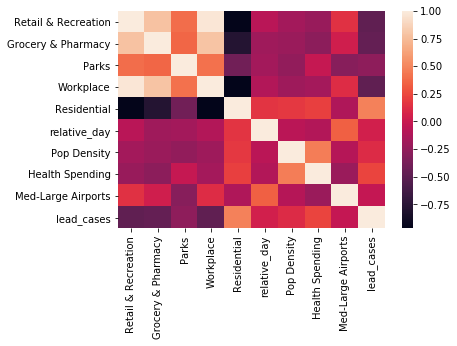

In [16]:
#check the correlation
corr = pd.concat([X,Y],axis=1).corr()
ax = sns.heatmap(corr)

### PCA on the three mobility index

In [17]:
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(X[['Retail & Recreation','Grocery & Pharmacy','Workplace']])
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1'])

In [18]:
X = X.drop(['Retail & Recreation','Grocery & Pharmacy','Workplace'],axis=1)
X['combined_mobility'] = principalDf['principal component 1']

In [19]:
vif=DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [20]:
vif.index = X.columns
vif

,VIF Factor
Parks,2.286298
Residential,34.323657
relative_day,4.959491
Pop Density,1.371416
Health Spending,23.144307
Med-Large Airports,2.078784
combined_mobility,10.660131


### Fit the model

In [21]:
model = sm.OLS(Y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             lead_cases   R-squared (uncentered):                   0.431
Model:                            OLS   Adj. R-squared (uncentered):              0.426
Method:                 Least Squares   F-statistic:                              93.64
Date:                Wed, 15 Apr 2020   Prob (F-statistic):                   1.64e-101
Time:                        03:42:07   Log-Likelihood:                         -4496.7
No. Observations:                 872   AIC:                                      9007.
Df Residuals:                     865   BIC:                                      9041.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Parks                 -0.2027      0.082     -2.473      0.014      -0.364      -0.042
Residential           -0.1479      0.745     -0.199      0.843      -1.609       1.314
relative_day          -0.1161      0.111     -1.050      0.294      -0.333       0.101
Pop Density           -0.0011      0.001     -1.037      0.300      -0.003       0.001
Health Spending        0.0040      0.001      4.885      0.000       0.002       0.006
Med-Large Airports     0.9574      0.814      1.177      0.240      -0.640       2.554
combined_mobility      0.9038      0.184      4.904      0.000       0.542       1.266
==============================================================================
Omnibus:                      844.264   Durbin-Watson:                   0.197
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29119.157
Skew:                           4.565   Prob(JB):                         0.00
Kurtosis:                      29.797   Cond. No.                     4.79e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Explore the relationship between the partisanship and the severity of COVID-19

In [141]:
#import data
aff = pd.read_csv('governor_party_affiliation.csv')

In [102]:
state_demo2 = state_demo.copy()

In [103]:
#calculate the infected/population
state_demo2['infected_pop'] = state_demo2['Infected']/state_demo2['Population']

In [119]:
#calculate the lenghth of time since the outbreak of each state
duration = pd.to_datetime('2020-04-15')-start_date

In [122]:
#merge the data
state_demo2 = state_demo2.merge(duration,left_on='State',right_index=True)

In [133]:
state_demo2['duration'] = state_demo2['date'].map(lambda x: str(x).split(' ')[0])

In [137]:
state_demo2['duration'] = state_demo2['duration'].astype('int')

In [138]:
#calcualte the (cases/population)/duration
state_demo2['final_case_ratio'] = state_demo2['infected_pop']/state_demo2['duration']

In [144]:
state_demo2 = state_demo2.merge(aff,left_on='State',right_on='State')

In [152]:
state_demo2['Party_affiliation'] = state_demo2['Party_affiliation'].map(lambda x: 1 if (x=='Republican') else 0)

In [164]:
# get the mean of final_case_ratio to get the sense of coefficients
Y.mean()

3.6879898202769015

### Fit the model

In [162]:
X = state_demo2[['Pop Density','Party_affiliation']]
Y = state_demo2['final_case_ratio']*100000
model = sm.OLS(Y, X).fit() ## sm.OLS(output, input)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       final_case_ratio   R-squared (uncentered):                   0.373
Model:                            OLS   Adj. R-squared (uncentered):              0.347
Method:                 Least Squares   F-statistic:                              14.29
Date:                Wed, 15 Apr 2020   Prob (F-statistic):                    1.35e-05
Time:                        04:53:45   Log-Likelihood:                         -149.75
No. Observations:                  50   AIC:                                      303.5
Df Residuals:                      48   BIC:                                      307.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Pop Density           0.0090      0.002      4.093      0.000       0.005       0.013
Party_affiliation     1.9555      1.024      1.909      0.062      -0.104       4.015
==============================================================================
Omnibus:                       36.847   Durbin-Watson:                   2.202
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               96.200
Skew:                           2.100   Prob(JB):                     1.29e-21
Kurtosis:                       8.342   Cond. No.                         490.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""